# Stock Market Prediction Using Numerical Analysis and Textual Analysis
GRIP @ The Sparks Foundation  
Data Science & Business Analytics Intern
### by: Pham Quang Chi  


### **Objective**: 
Predict the Indian Stock Exchange Sensitive Index - `SENSEX` from historical stock and news headlines data from 2015/01/01-31/03/2022.
### **Methodology** 
Two machine learning models `LSTM` and `LightGBM` are used and compared. The `LSTM` model is trained only on numerical data and acts as a Baseline model. The `LightGBM` model is trained on the numerical data and the additional Sentiment data. The Root Mean Squared Error `RMSE` metrics is used to evaluate the performance of both models.


#### Dataset:  
 - [Stock price](https://bit.ly/36fFPI6) 
 - [News Headlines](https://bit.ly/36fFPI6) 


In [1]:
# install Huggingface Transformers with PyTorch dependency
#!pip install transformers[torch]
# install LightGBM
#!pip install lightgbm

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from re import sub
import yfinance as yf

# HuggingFace RoBERTa pipline model
from transformers import pipeline

from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

# LSTM model
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# LightGBM model
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import BaggingRegressor

# Evaluation metrics
from sklearn.metrics import mean_squared_error

## Numerical Data Pre-processing

In [3]:
# fetch Daily historical stock data from yahoo finance for BSE SENSEX 
# accordling with our news headlines datetime range
# which is from '2001-01-01' up until '2022-03-31
stock = yf.download('^BSESN', start='2015-01-01', end='2022-03-31')
stock.info()
stock.head()


[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1781 entries, 2015-01-02 to 2022-03-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1781 non-null   float64
 1   High       1781 non-null   float64
 2   Low        1781 non-null   float64
 3   Close      1781 non-null   float64
 4   Adj Close  1781 non-null   float64
 5   Volume     1781 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 97.4 KB


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27521.279297,27937.470703,27519.259766,27887.900391,27887.900391,7400
2015-01-05,27978.429688,28064.490234,27786.849609,27842.320312,27842.320312,9200
2015-01-06,27694.230469,27698.929688,26937.060547,26987.460938,26987.460938,14100
2015-01-07,26983.429688,27051.599609,26776.119141,26908.820312,26908.820312,12200
2015-01-08,27178.769531,27316.410156,27101.939453,27274.710938,27274.710938,8200


In [4]:
# check for missing values
stock.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## Log-Returns of stock price
Arithmetic-returns: $r_{t} = price_{t} / price_{t-1} - 1$  
Arithmetic-returns are **multipicative** where:  
 $r_{t} = \prod_{t=1}^{T}(1+r_{t})$  

Log-returns: $z_{t} = \log(price_{t}) - \log(price_{t-1})$   
Log-returns are **additive** where:  
  $z_{t} = \sum_{t=1}^{T}\log(1+r_{t})$  
  
Log-returns are preferred over Arithmetic-returns based on the probability theory rule:
- The distribtution of the product of random variables is not identical to the distribution which the random varibles are drawn from.
- The distribtution of the sum of random variables is of the same type as the distribution of the random variables.
    
*Therefore we can attain a more stable distribution from Log-returns and a statistical model can be built with better accuracy*.

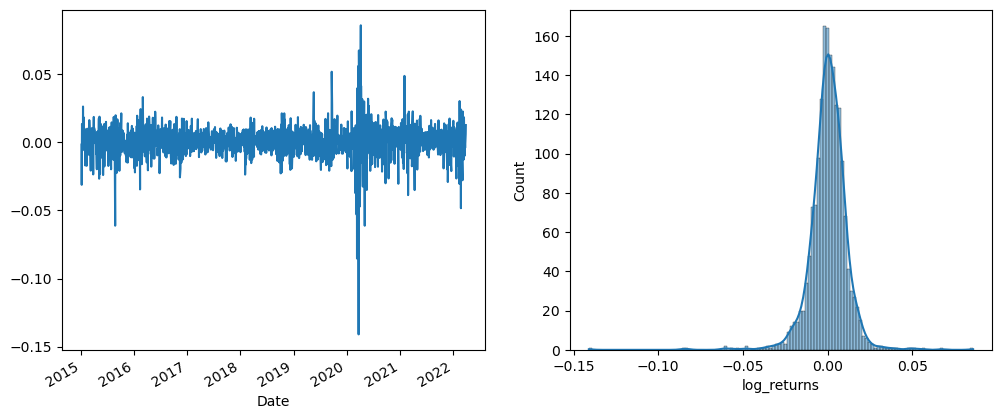

In [5]:
log_ret = np.log(stock['Adj Close']) - np.log(stock['Adj Close'].shift(1))
log_ret.dropna(inplace=True)
log_ret = log_ret.rename('log_returns')

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
log_ret.plot(ax=ax[0])
sns.histplot(log_ret, kde=True, ax=ax[1]);

## EDA on numerical data

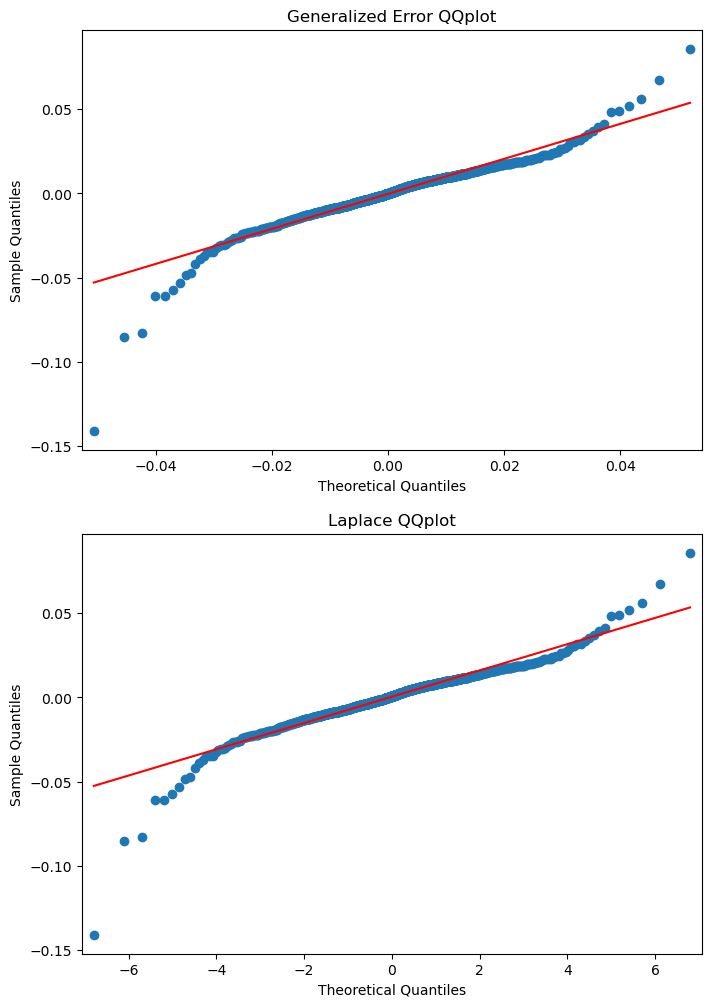

In [6]:
# QQ plots for Generalized Error and Laplace distributions
from scipy.stats import laplace, gennorm
# Fit a generalized normal distribution to the data
params = gennorm.fit(log_ret)

fig, ax = plt.subplots(2, 1, figsize=(8, 12))
qqplot(log_ret, dist=gennorm(*params), line='r', ax=ax[0])
qqplot(log_ret, dist=laplace(), line='r', ax=ax[1])
ax[0].set_title('Generalized Error QQplot')
ax[1].set_title('Laplace QQplot');


In [7]:
# check for stationarity
adf_test = adfuller(log_ret, autolag='AIC')
# get p-value
adf_test[1]

3.689313269083327e-21

P-value < 0.05 -> Our data appears to be stationary

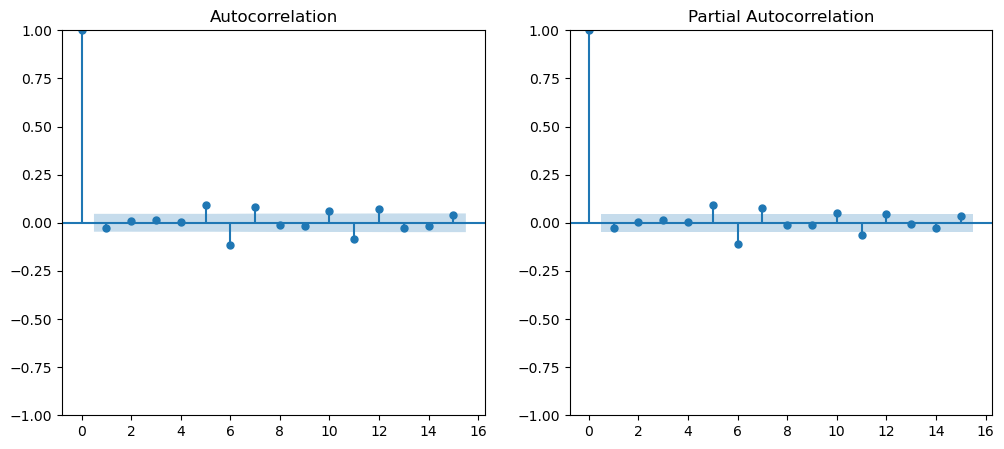

In [8]:
# plot ACF and PACF
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(log_ret, lags=15, ax=ax[0])
plot_pacf(log_ret, lags=15, method='ywmle', ax=ax[1]);

Taking the logarithms of returns eliminates any significant autocorrelation

In [41]:
# Check for correlation between today Price versus
# yesterday Price and log returns

yesterday_price = stock['Adj Close'].shift(1).dropna()
yesterday_price = yesterday_price.rename('yesterday_price')
yesterday_log_ret = log_ret.shift(1).dropna()
yesterday_log_ret = yesterday_log_ret.rename('yesterday_log_ret')
# concat 3 series into a dataframe
num_df = pd.concat([stock['Adj Close'][2:], yesterday_price[1:], yesterday_log_ret], axis=1)
# Pearson R -Linear Correlation
r = num_df.corr(method='pearson')
print('Pearson R:\n', r.iloc[0,1:])
print('------------------------------------')
# NonLinear Correlation
# Spearman
rho = num_df.corr(method='spearman')
print('Spearman R:\n', rho.iloc[0,1:])
print('------------------------------------')
# Kendall
tau = num_df.corr(method='kendall')
print('Kendall Tau:\n', tau.iloc[0,1:])


Pearson R:
 yesterday_price      0.999110
yesterday_log_ret    0.036841
Name: Adj Close, dtype: float64
------------------------------------
Spearman R:
 yesterday_price      0.998191
yesterday_log_ret    0.055597
Name: Adj Close, dtype: float64
------------------------------------
Kendall Tau:
 yesterday_price      0.968565
yesterday_log_ret    0.038262
Name: Adj Close, dtype: float64


The yesterday Close prices, Log-returns and Volumns will be our predictor features for our Baseline numerical model to predict the Today Close price. 

## Baseline `LSTM` 
This model is a two-layer LSTM network with 128 and 64 neurons respectively followed by two dense layers of 25 and 1 neurons.  
The model is trained on a sliding window of the previous **60** data observations to predict the today Close price.  
The model architecture is based on the following research paper:  
[Stock Price Prediction using Sentiment Analysis and Deep Learning for Indian Markets](https://arxiv.org/abs/2204.05783) 


In [11]:
# convert our df to numpy array
data = num_df.values
# sliding window
T = 60

In [12]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1)).fit(data)
scaled_data = scaler.fit_transform(data)


def create_data(data, look_back=T):
    X, y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back), 1:])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

X, y = create_data(scaled_data)

# Split into train and test sets
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.9)
trainX, valX, testX = X[:train_size,:], X[train_size:val_size,:],  X[val_size:len(X),:]
trainY, valY, testY = y[:train_size], y[train_size:val_size] , y[val_size:len(y)]

# Reshape input data to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 2))
valX = np.reshape(valX, (valX.shape[0], valX.shape[1], 2))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 2))

# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(128, input_shape=(T, 2)))
model.add(Dense(64))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
model.fit(trainX, trainY, validation_data=(valX, valY), epochs=100, batch_size=32, verbose=0)

# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Inverse transform the train and test Y
LSTM_trainY = scaler.inverse_transform(np.hstack((trainY.reshape(-1,1), np.zeros((len(trainY), 2)))))[:,0]
LSTM_testY = scaler.inverse_transform(np.hstack((testY.reshape(-1,1), np.zeros((len(testY), 2)))))[:,0]

# Inverse transform the predictions
LSTM_trainPredict = scaler.inverse_transform(np.hstack((trainPredict.reshape(-1,1), np.zeros((len(trainPredict), 2)))))[:,0]
LSTM_testPredict = scaler.inverse_transform(np.hstack((testPredict.reshape(-1,1), np.zeros((len(testPredict), 2)))))[:,0]


6/6 [==============================] - 0s 17ms/step


## Textual Data Pre-processing

In [13]:
# import the downloaded news headlines data
news = pd.read_csv(r"C:\Users\Steven\Downloads\india-news-headlines.csv", engine='c')
news.info()
news.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650970 entries, 0 to 3650969
Data columns (total 3 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   publish_date       int64 
 1   headline_category  object
 2   headline_text      object
dtypes: int64(1), object(2)
memory usage: 83.6+ MB


,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [14]:
# parse date, rename and set as index
news['publish_date'] = pd.to_datetime(news['publish_date'], format='%Y%m%d')
news.rename(columns={'publish_date': 'Date'}, inplace=True)
news = news.set_index('Date')
# pertain the data post 2015-01-01
news = news['2015-01-01':]
# rename the `headline_text` column to `Headlines`
news.rename(columns={'headline_text': 'Headlines'}, inplace=True)
# remove the unecessary `headline_category` column
news = news.drop(['headline_category'], axis=1)

news.tail()

,Headlines
Date,
2022-03-31,J&K sacks 2 cops; 3 other employees over terro...
2022-03-31,Ranbir Kapoor says 'Rishi Kapoor enjoyed his a...
2022-03-31,As Covid-19 cases drop to nil in southern dist...
2022-03-31,Tamil Nadu sees marginal rise of Covid cases w...
2022-03-31,Tamil Nadu sees marginal rise of Covid cases w...


In [15]:
# our News data seems to have duplicates
# remove duplicate headlines
news.drop_duplicates(inplace=True)

In [16]:
# remove special characters in the headlines
clean_headlines = []
for i in range(0, len(news)):
    # The regular expression `\W+` matches any non-alphanumeric characters
    clean_headlines.append(sub(r'\W+', ' ', news['Headlines'][i]))

# replace with the cleaned headlines    
news['Headlines'] = clean_headlines
news['Headlines'][:5]


Date
2015-01-01    Breakfast recipe for diabetics Moong idlis
2015-01-01                Recipe Delicious coconut balls
2015-01-01                  Cure that dandruff naturally
2015-01-01                   Recipe Kerala Chicken curry
2015-01-01                           Recipe Mocha Coffee
Name: Headlines, dtype: object

In [17]:
# group headlines by date
grouped_news = news.groupby(['Date']).agg({'Headlines': '. '.join})
grouped_news.head()

,Headlines
Date,
2015-01-01,Breakfast recipe for diabetics Moong idlis. Re...
2015-01-02,Drink smart with these party tips. How to say ...
2015-01-03,3 Stylish New Year cocktail recipes you ll LOV...
2015-01-04,How to get that bikini body. Rules of love mak...
2015-01-05,Recipe Strawberry cupcakes. Recipe Kaju jeera ...


## Sentiment Analysis
using the Huggingface pretrained RoBERTa `cardiffnlp/twitter-roberta-base-sentiment-latest` model

In [18]:
# instantiate the full-classification model
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from scipy.special import softmax

# Define model and tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
# Define a function to perform sentiment analysis
def get_sentiments(df, column):
    sentiments = {"negative": [], "neutral": [], "positive": []}
    for text in df[column]:
        encoded_input = tokenizer(text, max_length=512, truncation=True, return_tensors='pt')
        output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        scores = torch.nn.functional.softmax(torch.tensor(scores), dim=0)
        for i, label in enumerate(["negative", "neutral", "positive"]):
            sentiments[label].append(scores[i].item())
    return sentiments

sentiment_scores = get_sentiments(grouped_news, 'Headlines')

In [22]:
# Create our sentiment dataframe
sentiment_df = pd.DataFrame(sentiment_scores, index=grouped_news.index)
sentiment_df.head()

,negative,neutral,positive
Date,,,
2015-01-01,0.038320,0.668400,0.293279
2015-01-02,0.082853,0.680551,0.236596
2015-01-03,0.059572,0.514002,0.426426
2015-01-04,0.039752,0.587957,0.372292
2015-01-05,0.123824,0.772273,0.103903


## `LightGBM`
In this section, we will use the previous **60** day Close Prices, Log-returns, Volumns and sentiment scores (including today scores) as our 6 predictor features.  
Statistical measures which are the mean, standard deviation, maximum, minimum and percentile values of our preditors are combined into a feature matrix as the input to the LightGBM model.

In [23]:
# merge the sentiment scores with the numerical df
df = pd.merge(num_df, sentiment_df.iloc[5:], how='inner', on='Date')
print(df.head())
# convert to numpy array for model training
data = df.values
# Define the sliding window length
T = 60

               Adj Close  yesterday_price  yesterday_log_ret  negative  \
Date                                                                     
2015-01-06  26987.460938     27842.320312          -0.001636  0.029923   
2015-01-07  26908.820312     26987.460938          -0.031185  0.046298   
2015-01-08  27274.710938     26908.820312          -0.002918  0.084145   
2015-01-09  27458.380859     27274.710938           0.013506  0.314897   
2015-01-12  27585.269531     27458.380859           0.006712  0.014138   

             neutral  positive  
Date                            
2015-01-06  0.313757  0.656320  
2015-01-07  0.533188  0.420514  
2015-01-08  0.746031  0.169823  
2015-01-09  0.536853  0.148250  
2015-01-12  0.528707  0.457155  


In [25]:
# Compute the statistical features for each window which are:
# the mean, standard deviation, maximum, minimum and percentile values 
# of the past log returns and sentiment scores
features = []
for i in range(len(data) - T):
    window = data[i:i+T, 1:]
    mean = np.mean(window, axis=0)
    std = np.std(window, axis=0)
    maximum = np.max(window, axis=0)
    minimum = np.min(window, axis=0)
    percentiles = np.percentile(window, [25, 50, 75], axis=0)
    feature_matrix = np.concatenate((mean, std, maximum, minimum, percentiles.flatten()))
    features.append(feature_matrix)

# Convert to NumPy array
features = np.array(features)

# Split into train and test sets
train_size = int(len(features) * 0.8)
trainX, testX = features[:train_size,:], features[train_size:len(features),:]
LGBM_trainY, LGBM_testY = data[T:T+train_size, 0], data[T+train_size:len(data), 0]

# Define the hyperparameter search space
param_distributions = {
    'num_leaves': [10, 20, 30],
    'max_depth': [5, 10],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
}

# Instantiate the LightGBM Regressor model
model = LGBMRegressor(random_state=42)

# Instantiate the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    random_state=42,
)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(trainX, LGBM_trainY)

# Print the best hyperparameters found by RandomizedSearchCV
print("Best Hyperparameters:", random_search.best_params_)

# Instantiate the BaggingRegressor object with the best hyperparameters
model = BaggingRegressor(
    base_estimator=LGBMRegressor(**random_search.best_params_, random_state=42),
    n_estimators=10,
    random_state=42,
)

# Fit the BaggingRegressor model to the training data
model.fit(trainX, LGBM_trainY)

# Make predictions
LGBM_trainPredict = model.predict(trainX)
LGBM_testPredict = model.predict(testX)


Best Hyperparameters: {'num_leaves': 10, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1}


c:\Users\Steven\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


## Evaluate results

In [26]:
# Compute and compare the RMSE of our 2 models
# LSTM 
LSTM_trainScore = np.sqrt(mean_squared_error(LSTM_trainY, LSTM_trainPredict))
print('LSTM Train Score: %.2f RMSE' % (LSTM_trainScore))
LSTM_testScore = np.sqrt(mean_squared_error(LSTM_testY, LSTM_testPredict))
print('LSTM Test Score: %.2f RMSE' % (LSTM_testScore))
# LightGBM
LGBM_trainScore = np.sqrt(mean_squared_error(LGBM_trainY, LGBM_trainPredict))
print('LightGBM Train Score: %.2f RMSE' % (LGBM_trainScore))
LGBM_testScore = np.sqrt(mean_squared_error(LGBM_testY, LGBM_testPredict))
print('LightGBM Test Score: %.2f RMSE' % (LGBM_testScore))


LSTM Train Score: 548.38 RMSE
LSTM Test Score: 2039.50 RMSE
LightGBM Train Score: 261.77 RMSE
LightGBM Test Score: 14593.06 RMSE


It appears our Baseline `LSTM` model which is trained on numberical data only is the better performer for this task and the additional sentiment scores **as input for the `LightGBM` model** have no effects on improving the prediction quality.

# LSTM with Numerical and Textual analysis
Let us try training the `LSTM` on our complete dataset and see if there is an improvement in performance

In [29]:
# Create dataset
df = pd.merge(num_df, sentiment_df.iloc[5:], how='inner', on='Date')
# convert to numpy array for model training
data = df.values
# Define the sliding window length
T = 60
# sliding window
T = 60

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1)).fit(data)
scaled_data = scaler.fit_transform(data)


def create_data(data, look_back=T):
    X, y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back), 1:])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

X, y = create_data(scaled_data)

# Split into train and test sets
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.9)
trainX, valX, testX = X[:train_size,:], X[train_size:val_size,:],  X[val_size:len(X),:]
trainY, valY, testY = y[:train_size], y[train_size:val_size] , y[val_size:len(y)]

# Reshape input data to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 5))
valX = np.reshape(valX, (valX.shape[0], valX.shape[1], 5))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 5))

# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(128, input_shape=(T, 5)))
model.add(Dense(64))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
model.fit(trainX, trainY, validation_data=(valX, valY), epochs=100, batch_size=32, verbose=0)

# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Inverse transform the train and test Y
LSTM_trainY_final = scaler.inverse_transform(np.hstack((trainY.reshape(-1,1), np.zeros((len(trainY), 5)))))[:,0]
LSTM_testY_final = scaler.inverse_transform(np.hstack((testY.reshape(-1,1), np.zeros((len(testY), 5)))))[:,0]

# Inverse transform the predictions
LSTM_trainPredict_final = scaler.inverse_transform(np.hstack((trainPredict.reshape(-1,1), np.zeros((len(trainPredict), 5)))))[:,0]
LSTM_testPredict_final = scaler.inverse_transform(np.hstack((testPredict.reshape(-1,1), np.zeros((len(testPredict), 5)))))[:,0]


6/6 [==============================] - 0s 16ms/step


In [30]:
# compare the RMSE of the 2 LSTM models
# Basline LSTM 
LSTM_trainScore = np.sqrt(mean_squared_error(LSTM_trainY, LSTM_trainPredict))
print('Baseline Train Score: %.2f RMSE' % (LSTM_trainScore))
LSTM_testScore = np.sqrt(mean_squared_error(LSTM_testY, LSTM_testPredict))
print('Baseline Test Score: %.2f RMSE' % (LSTM_testScore))
# Final LSTM
LSTM_trainScore_final = np.sqrt(mean_squared_error(LSTM_trainY_final, LSTM_trainPredict_final))
print('Final Train Score: %.2f RMSE' % (LSTM_trainScore_final))
LSTM_testScore_final = np.sqrt(mean_squared_error(LSTM_testY_final, LSTM_testPredict_final))
print('Final Test Score: %.2f RMSE' % (LSTM_testScore_final))

Baseline Train Score: 548.38 RMSE
Baseline Test Score: 2039.50 RMSE
Final Train Score: 494.50 RMSE
Final Test Score: 3709.82 RMSE


Adding sentiment scores seems to only make the `LSTM` model overfit more to past data and less generlized for testing data.

# Model Validation
## `LSTM` and Return Prediction
This section will explore the common mistake in using the `LSTM` neuronets for stock price prediction.  
To demonstate, the `LSTM` model will predict the today Logarithmic Returns instead of Daily Close Prices and is trained on the same feature matrix of previous 60 day Log-Returns and Close Prices.  
For consistency, the model architecture also remains the same as the Basline model's.

In [49]:
# define our dataset with log returns as the target vector
df = pd.concat([log_ret.iloc[1:], yesterday_log_ret, yesterday_price.iloc[1:]], axis=1)
data = df.values
# sliding window
T = 60

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1)).fit(data)
scaled_data = scaler.fit_transform(data)


def create_data(data, look_back=T):
    X, y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back), 1:])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

X, y = create_data(scaled_data)

# Split into train and test sets
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.9)
trainX, valX, testX = X[:train_size,:], X[train_size:val_size,:],  X[val_size:len(X),:]
trainY, valY, testY = y[:train_size], y[train_size:val_size] , y[val_size:len(y)]

# Reshape input data to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 2))
valX = np.reshape(valX, (valX.shape[0], valX.shape[1], 2))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 2))

# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(128, input_shape=(T, 2)))
model.add(Dense(64))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
model.fit(trainX, trainY, validation_data=(valX, valY), epochs=100, batch_size=32, verbose=0)

# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Inverse transform the train and test Y
LSTM_trainY_log = scaler.inverse_transform(np.hstack((trainY.reshape(-1,1), np.zeros((len(trainY), 2)))))[:,0]
LSTM_testY_log = scaler.inverse_transform(np.hstack((testY.reshape(-1,1), np.zeros((len(testY), 2)))))[:,0]

# Inverse transform the predictions
LSTM_trainPredict_log = scaler.inverse_transform(np.hstack((trainPredict.reshape(-1,1), np.zeros((len(trainPredict), 2)))))[:,0]
LSTM_testPredict_log = scaler.inverse_transform(np.hstack((testPredict.reshape(-1,1), np.zeros((len(testPredict), 2)))))[:,0]


6/6 [==============================] - 0s 16ms/step


In [50]:
# RMSE
LSTM_trainScore_log = np.sqrt(mean_squared_error(LSTM_trainY_log, LSTM_trainPredict_log))
print('Train Score: %.2f RMSE' % (LSTM_trainScore_log))
LSTM_testScore_log = np.sqrt(mean_squared_error(LSTM_testY_log, LSTM_testPredict_log))
print('Test Score: %.2f RMSE' % (LSTM_testScore_log))

Train Score: 0.01 RMSE
Test Score: 0.01 RMSE


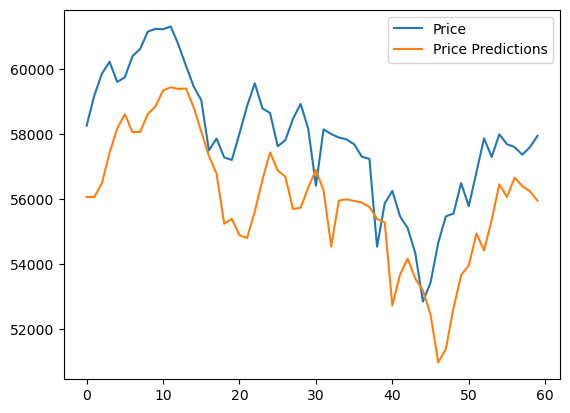

In [59]:
# plot the Baseline LSTM model's last 60 predictions
plt.plot(LSTM_testY[-60:], label='Price')
plt.plot(LSTM_testPredict[-60:], label='Price Predictions')
plt.legend();

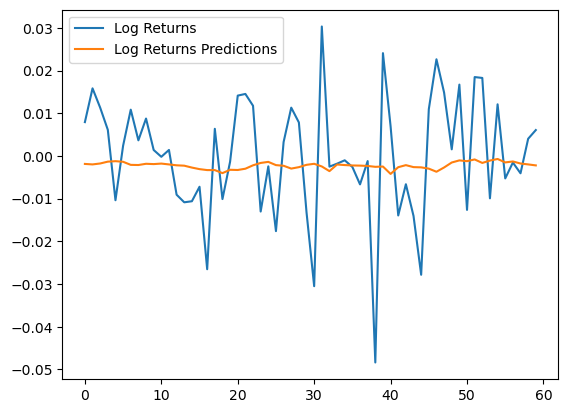

In [60]:
# Plot the LSTM Log-returns last's 60 predictions 
plt.plot(LSTM_testY_log[-60:], label='Log Returns')
plt.plot(LSTM_testPredict_log[-60:], label='Log Returns Predictions')
plt.legend();

The reason for such drastic drop-off in predicting performance with stock returns is due to the `LSTM` model design where the previous Close prices are used to predict the next Close price, the model simply learns and estimates the patterns in past data and the projection of the next data point will always be in close approximation to the last data point.  
In other words, the 'pretty-looking' predictions of the `LSTM` model on *Stock Price* data can be thought of as the actual data itself shifted backward by 1 point.
  
    
*Therefore, thorough research should be done before implementing the `LSTM` neuro networks for stock prediction.*
